# Question 0 

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np

# Max likelihood estimation
In this case we need to add up the times it swithced between a the states.

Questions: I have summed over all rows and columns this may not be true? do we do one then the other?

In [2]:
N = 500
T = 100

data_file = 'meteo0.csv'
data = np.ones((N, T))
with open(data_file) as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter =' ')
    count=0
    for row in csvReader:
        for n in range(len(row)):
            data[count, n] = row[n]
        count +=1   

In [3]:
p_v1_0 = np.sum([data[:,0] == 0])
p_v1_1 = np.sum([data[:,0] == 1])
p_v1_2 = np.sum([data[:,0] == 2])
print(p_v1_0, p_v1_1,p_v1_2)

p_v1 = [p_v1_0/N, p_v1_1/N, p_v1_2/N]
print(p_v1)

154 256 90
[0.308, 0.512, 0.18]


In [4]:
### p(vt+1 = 0| vt =1)
A = np.zeros((3,3))

for i in range(N):
    for j in range(T-1):
        A[int(data[i,j]), int(data[i,j+1])] += 1/N


for i in range(3):
    A[:,i] = A[:,i]/np.sum(A[:,i])

print(A)       

[[0.7        0.16831816 0.        ]
 [0.18102894 0.70075775 0.30236498]
 [0.11897106 0.13092409 0.69763502]]


# Question 2

forward backward algorithm


In [5]:
V = np.array([0, 1, 0, 2, 0, 2, 1, 0, 2, 0])
#Emmission
A = np.array([[0.3, 0.5], [0.6,0],[0.1,0.5]])
#Transition
T = np.array([[0.5,0.8], [0.5, 0.2]])

initial_dist = np.array([[1,0]])


def forward(V, A, T, initial_dist):
    alpha = np.zeros((V.shape[0], T.shape[0]))
    alpha[0,:] = initial_dist*A[V[0],:]
    alpha[0,:] = alpha[0,:]/np.sum(alpha[0,:])
    
    for t in range(1, V.shape[0]):
        for j in range(T.shape[0]):
            alpha[t,j] = alpha[t-1]@T[j,:]*A[V[t], j]
        
        alpha[t,:] = alpha[t,:]/np.sum(alpha[t,:])
    
    return alpha

alpha = forward(V,A,T, initial_dist)

def backward(V, A, T):
    beta = np.zeros((V.shape[0], T.shape[0]))
    beta[V.shape[0] - 1,:] = np.ones((T.shape[0]))
    beta[V.shape[0] - 1,:] = beta[V.shape[0] - 1,:]/np.sum(beta[V.shape[0] - 1,:])
    
    for t in range(V.shape[0] -2, -1, -1):
        for j in range(T.shape[0]):
            beta[t,j]=(beta[t+1]* A[V[t+1],:])@T[:,j]
    
        beta[t,:] = beta[t,:]/np.sum(beta[t,:])
    return beta

beta = backward(V,A,T)

p_ht = np.zeros((T.shape[0],V.shape[0]))

for t in range(0,V.shape[0]):
    p_ht[0,t] = alpha[t,0]*beta[t,0] #*A[V[t],0]
    p_ht[1,t] = alpha[t,1]*beta[t,1] #*A[V[t],1]


p_ht = (p_ht/np.sum(p_ht, axis = 0)).T
print(p_ht)
    

[[1.         0.        ]
 [1.         0.        ]
 [0.50239234 0.49760766]
 [0.29824561 0.70175439]
 [0.73205742 0.26794258]
 [0.17065391 0.82934609]
 [1.         0.        ]
 [0.48837209 0.51162791]
 [0.34108527 0.65891473]
 [0.59302326 0.40697674]]


In [6]:
p_h1_h2 = np.zeros(T.shape)
p_h4_h5 = np.zeros(T.shape)

for i in range(p_h1_h2.shape[0]):
    for j in range(p_h1_h2.shape[1]):
        p_h1_h2[i,j] = alpha[0,i]* beta[1, j]*T[i,j]*A[V[1],j] #*A[V[0],i]
        p_h4_h5[i,j] = alpha[3,i]* beta[4, j]*T[i,j]*A[V[4],j] #*A[V[3],i]

p_h1_h2=p_h1_h2/np.sum(p_h1_h2)
print(np.sum(np.sum(p_h1_h2)))
p_h4_h5 = p_h4_h5/np.sum(p_h4_h5)
print(np.sum(np.sum(p_h4_h5)))

1.0
1.0000000000000002


# EM algorithm

In [7]:
def log_like(x):
    c=x.max()
    return c + np.log2(np.sum(np.exp(x-c)))


In [8]:
def calcLogLike(V, A, TEst, initial_dist):
    """
    logLike = 0
    like = np.zeros((2,len(V)))
    
    for t in range(len(V)):
        for i in range(2):
            for j in range(2):
                like
    
    """
    epsilon = 0.0001
    logLike = 0
    
    for i in range(2):
        if initial_dist[0, i]*A[V[0],i] > 0+epsilon:
            logLike += np.log(initial_dist[0, i]*A[V[0],i])
            
    for t in range(1,len(V)):
        for i in range(2):
            if A[V[t],i]>0+epsilon:
                logLike += np.log(A[V[t],i])
            for j in range(2):
                if TEst[i,j]>0+epsilon:
                    logLike += np.log(TEst[i,j])
    
    logLike = log_like(logLike)
    
    
    return logLike

    

In [25]:
def baum_welch(data, A, initial_dist):
    #Intialise transition matrxix to update
    #T = np.array([[0.4,0.7], [0.6, 0.3]])
    T = np.array([[0.5,0.8], [0.5, 0.2]])
    ndata = data.shape[0]
    
    response = np.zeros((2,2,ndata))
    
    #response[:,0] = initial_dist[0]
    loglikes=[]
    
    loglikes.append(calcLogLike(data, A, T, initial_dist))
    #print(loglikes[0])
    nIter = 0
    running = True
    while running:
        #E step - update the probability distribtuion p(ht, ht+1|v, \theta)
        #Given the current T we want to update the posterior dist on hts
        
        alpha = forward(data, A, T, initial_dist)
        beta = backward(data, A, T)
        
        
        for t in range(0,ndata-1):
            for i in range(2):
                for j in range(2):
                    response[i,j,t] = alpha[t,i]*beta[t+1, j]*T[i,j]*A[data[t+1],j] #*A[data[t],i]
                    
            summond = np.sum(response[:,:,t], axis=0)
            summond[summond==0]=1
            
            response[:,:,t] = response[:,:,t]/summond

        
        #M step - update parameters for T
        T_dum = np.zeros(T.shape)
        
        response_i = np.zeros((2, ndata))
        
        for t in range(ndata):
            for j in range(2):
                response_i[:,t] += response[:,j,t]
            
        
        for i in range(2):
            for j in range(2): 
                bottom = 0
                top = 0
                for t in range(0, ndata-1):
                    top += response[i,j, t]
                    bottom += response_i[i,t]
                
                T_dum[i,j] =  top/bottom                                   
             
        T_dum[:,0] = T_dum[:,0]/np.sum(T_dum[:,0]) 
        T_dum[:,1] = T_dum[:,1]/np.sum(T_dum[:,1])                                                
        
        
        if (np.linalg.norm(T - T_dum)==0) or nIter == 120:
            running =False
        nIter += 1  
        
        T = T_dum
        
        #print(T)
        loglike = calcLogLike(data, A, T, initial_dist)
        #print(loglike)
        loglikes.append(loglike)
    
    x = np.arange(nIter+1)
    plt.plot(x,loglikes)
    
    print(nIter)
    
    return T 

91


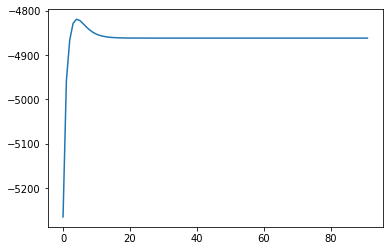

In [26]:
chess_results = []

f = open('chess.txt', 'r')
for item in f.read():
    if item != '\n':
        chess_results.append(int(item))

chess_results = np.array(chess_results) 

A = np.array([[0.3, 0.5], [0.6,0],[0.1,0.5]])

initial_dist = np.array([[1,0]])

forward(chess_results, A, np.array([[0.5,0.8], [0.5, 0.2]]), initial_dist)

T = baum_welch(chess_results, A, initial_dist)

In [27]:
print(T)
#print(chess_results)

[[0.56261703 0.41859284]
 [0.43738297 0.58140716]]


In [13]:
a = forward(chess_results, A, T, initial_dist)
b = backward(chess_results, A, T)
V = chess_results

p_h1000 =[]
p_h1000.append(a[1000-1,0]*b[1000-1,0]*A[V[1000-1],0])
p_h1000.append(a[1000-1,1]*b[1000-1,1]*A[V[1000-1],1])

print(V[999])
h1000 = np.argmax(p_h1000)
print(h1000)
h1001 = np.argmax(T[h1000,:])
print(h1001)

v1001 = np.argmax(A[:,h1001])
print(v1001) #50 50 whether visible  is 0 or 2

0
1
1
0
